# Pipeline for BIAPT lab EEG Preprocessing: 
#### inspired by: https://github.com/hoechenberger/pybrain_mne/
#### adapted by: Charlotte Maschke
#### This pipeline uses MNE Python to preprocess EEG data: Plese go here: 
####                                https://mne.tools/stable/overview/index.html
####  for more documentation on MNE Python

## Some setup and import

In [101]:
import matplotlib
#import mne_bids
import pathlib
import mne
import os
import os.path as op
from mne import viz

# interactive plotting functions.


from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs,
                               corrmap)
#import openneuro

#from mne_bids import BIDSPath, read_raw_bids, print_dir_tree, make_report

# Ensure Matplotlib uses the Qt5Agg backend, 
# which is the best choice for MNE-Python's 
# interactive plotting functions.
matplotlib.use('Qt5Agg')

import matplotlib.pyplot as plt

### Which subject do you want to preprocess? 

In [102]:
ID = "001"
session = "01"
task = "pre"

In [103]:
raw_path = "./Data/doc_tacs/sub-{}/ses-{}/eeg/sub-{}_ses-{}_task-{}_eeg.mff".format(ID,session,ID,session,task)
raw_path

'./Data/doc_tacs/sub-001/ses-01/eeg/sub-001_ses-01_task-pre_eeg.mff'

## Load the raw data!

In [104]:
raw = mne.io.read_raw_egi(raw_path)
raw

Reading EGI MFF Header from c:\Users\VivoBook\Documents\GitHub\GitHub_remote_version\Data\doc_tacs\sub-001\ses-01\eeg\sub-001_ses-01_task-pre_eeg.mff...
    Reading events ...
    Assembling measurement info ...


<RawMff | signal1.bin, 129 x 349992 (350.0 s), ~178 kB, data not loaded>

## Resample the data to 250

In [105]:
if raw.info['sfreq'] != 250:
    raw = raw.resample(250)

### Keep only the EEG

In [106]:
# this is to load EEG. If you want to load other stuff please refer to the website documetation
eeg = raw.pick_types(eeg = True)
print('Number of channels in EEG:')
len(eeg.ch_names)

Number of channels in EEG:


129

## Crop the data

Depending on the data, we may need to crop the begining or/and the end

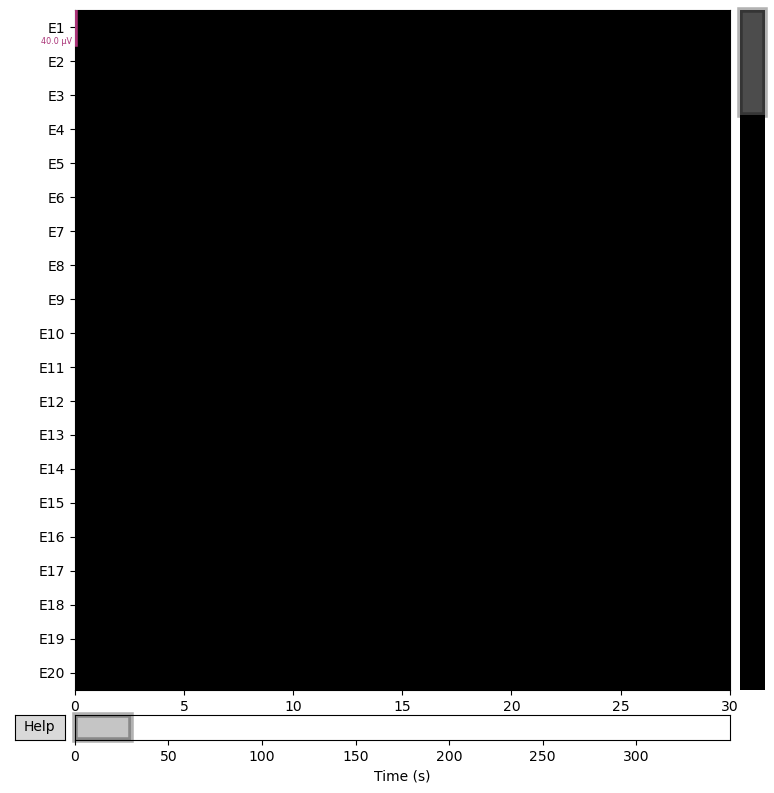

Channels marked as bad: none


In [107]:
eeg.plot(duration=30, title='raw')

In [111]:
eeg_cropped= eeg.crop(tmin=30.0)
#eeg_cropped.plot(duration=30, title='cropped')

## Filter the data

In [112]:
# load actual data into system (before it was only metadata)
eeg_cropped.load_data()
#eeg.load_data()

# filter the data between 1 to 55 Hz
eeg_cropped_filtered = eeg_cropped.filter(l_freq=1, h_freq = 55)
#eeg_filtered = eeg.filter(l_freq=1, h_freq = 55) 

# notch filter the data for freq =60
eeg_notch = eeg_cropped_filtered.copy().notch_filter(freqs=60)
#eeg_notch = eeg_filtered.notch_filter(freqs=60)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 55 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 55.00 Hz
- Upper transition bandwidth: 13.75 Hz (-6 dB cutoff frequency: 61.88 Hz)
- Filter length: 825 samples (3.300 sec)

Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 

In [113]:
%matplotlib qt
viz.plot_raw_psd(eeg_notch, exclude = ['E129'], fmax = 70)
plt.savefig('./out_figures/doc-tacs/sub-{}/ses-{}/task-{}/sub-{}_ses-{}_task-{}_PSD_raw_filtered.png'.format(ID,session,task,ID,session,task))

Effective window size : 8.192 (s)


## Visualize raw data to identify bad channels

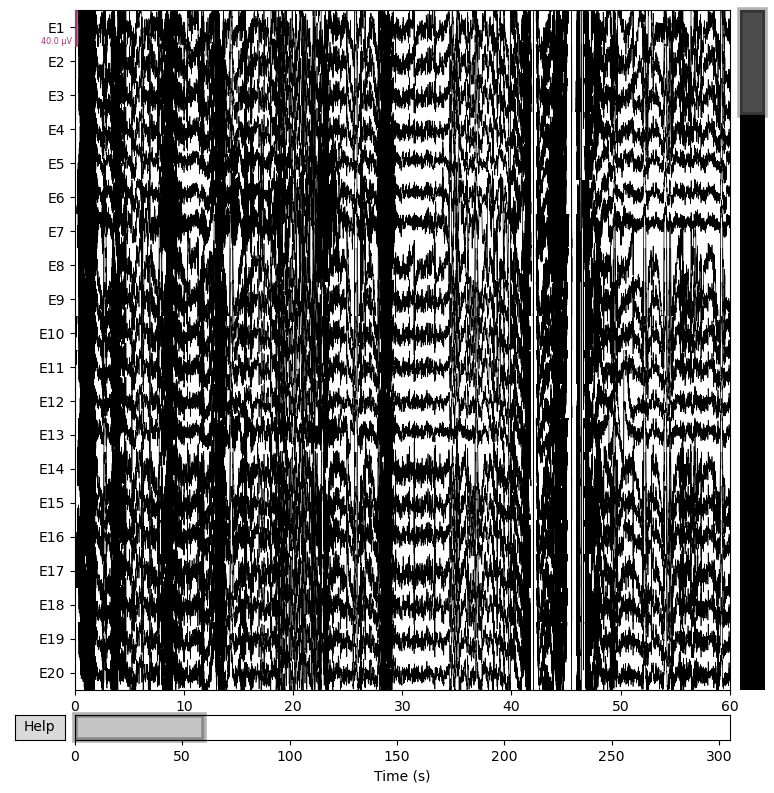

Channels marked as bad: ['E35', 'E100', 'E114']


In [114]:
#eeg_notch.plot()
#eeg_filtered.plot(n_channels=30, duration=30)
eeg_notch.plot(n_channels=20, duration=60)

Verify if labelled correctly

In [115]:
marked_bad = eeg_notch.info['bads']
marked_bad

['E35', 'E100', 'E114']

### Add chanels found bad afterward

In [116]:
bad_found_afterward= ['E13', 'E36', 'E44', 'E37', 'E41', 'E42', 'E31', 'E35', 'E29', 'E30', 'E33', 'E80', 'E87', 'E111', 'E112', 'E105', 'E106', 'E129']

for e in bad_found_afterward: 
    if e not in eeg_notch.info['bads']:
        marked_bad.append(e)

In [117]:
# save in a txt
with open('./eeg_output/doc-tacs/sub-{}/ses-{}/eeg/sub-{}_ses-{}_task-{}_marked_bads.json'.format(ID,session,ID,session,task), 'w') as outfile:
    outfile.write("\n".join(marked_bad))


# Interpolate bad channels

In [118]:
eeg_interpol = eeg_notch.interpolate_bads()

Interpolating bad channels
    Automatic origin fit: head of radius 99.1 mm
Computing interpolation matrix from 109 sensor positions
Interpolating 20 sensors


## Average Reference the data

In [119]:
# use the average of all channels as reference
eeg_avg_ref = eeg_interpol.set_eeg_reference(ref_channels='average')

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


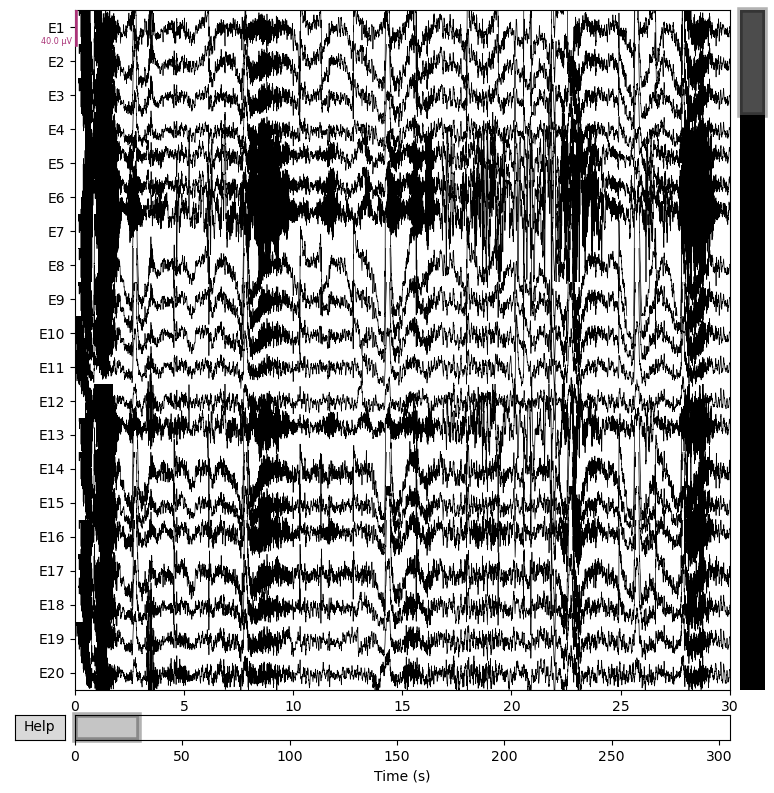

Channels marked as bad: none


In [120]:
eeg_avg_ref.plot(duration=30)

In [121]:
%matplotlib tk
viz.plot_raw_psd(eeg_avg_ref, fmax = 70)
plt.savefig('./out_figures/doc-tacs/sub-{}/ses-{}/task-{}/sub-{}_ses-{}_task-{}_PSD_avg_ref.png'.format(ID,session,task,ID,session,task))

Effective window size : 8.192 (s)


In [ ]:
print(eeg_avg_ref.info)

# RUN ICA

## Manual selection of ICA components

In [ ]:
# pick some channels that clearly show heartbeats and blinks
#eog_channels = ['E8', 'E12','E14','E21', 'E25', 'E126', 'E127']

In [122]:
#eeg_avg_ref.info['EOG channels']
from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs,
                               corrmap)

ica = ICA(n_components=15, max_iter='auto', random_state=97)
ica.fit(eeg_avg_ref)

Fitting ICA to data using 129 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 3.0s.


Method,fastica
Fit,26 iterations on raw data (76248 samples)
ICA components,15
Explained variance,99.4 %
Available PCA components,129
Channel types,eeg
ICA components marked for exclusion,—


Creating RawArray with float64 data, n_channels=15, n_times=76248
    Range : 11250 ... 87497 =     45.000 ...   349.988 secs
Ready.


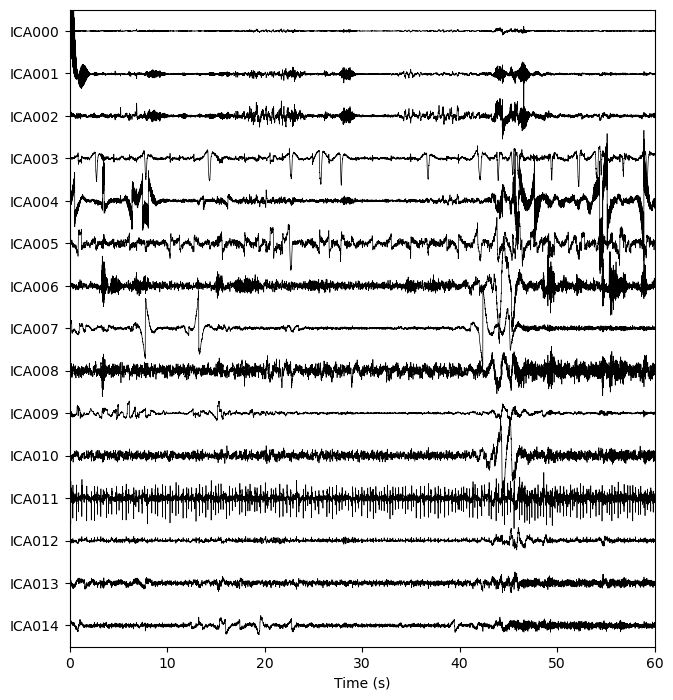

In [123]:
ica.plot_sources(eeg_avg_ref, show_scrollbars=False, stop = 60)


In [125]:
ica.plot_components()

[<MNEFigure size 975x731 with 15 Axes>]

In [126]:
ica

Method,fastica
Fit,26 iterations on raw data (76248 samples)
ICA components,15
Explained variance,99.4 %
Available PCA components,129
Channel types,eeg
ICA components marked for exclusion,ICA005ICA003


Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 2 ICA components
    Projecting back using 129 PCA components


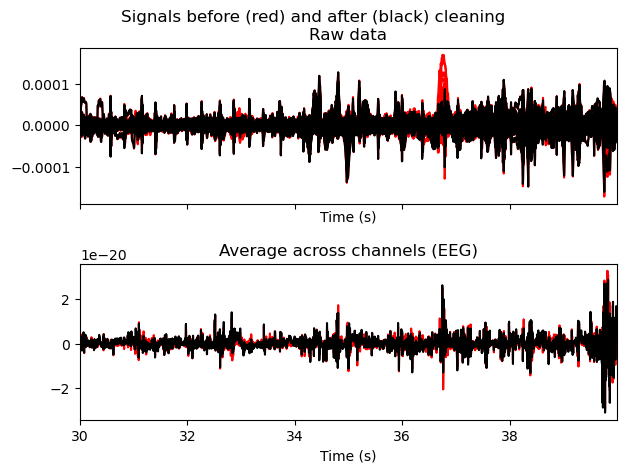

In [127]:
# blinks
ica.plot_overlay(eeg_avg_ref, start = 30*250, stop = 40*250)
#ica.plot_overlay(eeg_avg_ref, exclude=[0,1,2,3],start = 30*250, stop = 40*250)

Double check which component to remove: 

In [128]:
ica.exclude

[5, 3]

Remove component definetely

In [129]:
eeg_postica = eeg_avg_ref.copy()
ica.apply(eeg_postica)

Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 2 ICA components
    Projecting back using 129 PCA components


<RawMff | signal1.bin, 129 x 76248 (305.0 s), ~75.2 MB, data loaded>

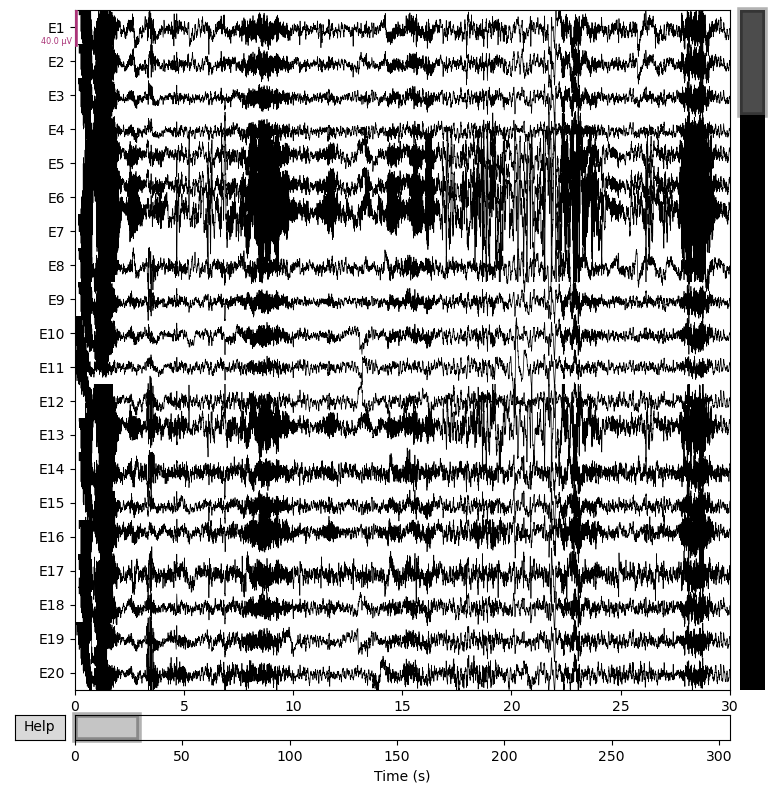

Channels marked as bad: none
Channels marked as bad: none


In [130]:
# PLot to compare both signals pre and post ICA
eeg_avg_ref.plot(title='raw', duration =30)
eeg_postica.plot(title='ICA correction', duration =30)

## Remove Non-Brain Electrodes and bad channels 

In [ ]:
non_brain_el = ['E127', 'E126', 'E17', 'E21', 'E14', 'E25', 'E8', 'E128', 'E125', 'E43', 'E120', 'E48', 
                'E119', 'E49', 'E113', 'E81', 'E73', 'E88', 'E68', 'E94', 'E63', 'E99', 'E56', 'E107' ]

#only add non-brain channels if not already part of noisy channels
for e in non_brain_el: 
    if e not in eeg_avg_ref.info['bads']:
        eeg_postica.info['bads'].append(e)


In [ ]:
#print(eeg_postica.info['bads'])

In [ ]:
# remove channels marked as bad and non-brain channels
eeg_brainonly = eeg_postica.copy().drop_channels(eeg_postica.info['bads'])
eeg_brainonly

In [ ]:
eeg_brainonly.plot(title='brain only', duration=10)

## Save final non brain data

In [ ]:
#out_dir = pathlib.Path("./Results/sub-{}/ses-{}/eeg/".format(ID,session))

#if not os.path.exists(out_dir):
    #os.makedirs(out_dir)
    
#out_path = pathlib.Path(out_dir, "sub-{}_ses-{}_task-{}.set".format(ID,session,task))

In [ ]:
eeg_brainonly.save("./eeg_output/doc-tacs/sub-{}/ses-{}/eeg/sub-{}_ses-{}_task-{}_{}_eeg.fif".format(ID, session, ID, session, task, 'nonbrainfiltered'), overwrite=True)
#ici changer pour le sauver dans derivatives, dossier clean (avec un readme expliquant le cleaning) et le fichier sous le bids format

# Make epochs of 10 s

In [ ]:
epochs = mne.make_fixed_length_epochs(eeg_brainonly, duration = 10, overlap=0)

In [ ]:
epochs.plot(n_epochs=3, n_channels=100, scalings=20e-6)

In [ ]:

# epochs.drop_bad()  double check on this


In [ ]:
epochs

In [ ]:
epochs.save(("./eeg_output/doc-tacs/sub-{}/ses-{}/eeg/sub-{}_ses-{}_task-{}_{}_eeg.fif".format(ID, session, ID, session, task, 'epoch')),overwrite=True)
